In [13]:
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback
# from fastprogress.fastprogress import master_bar, progress_bar

from gepcore.utils import convolution
from gepcore.utils import cell_graph
from gepcore.entity import Gene, Chromosome
from gepcore.symbol import PrimitiveSet
from nas_seg.seg_model import get_net, arch_config, Network
from nas_seg.utils import code_to_rgb
from nas_seg.isprs_dataset import ISPRSDataset, img_to_mask, mask_to_img
from pygraphviz import AGraph
import glob

#from tqdm import tqdm
from skimage import io
from sklearn.metrics import confusion_matrix

if torch.cuda.is_available():
  print("Great! Good to go!")
else:
  print('CUDA is not up!')

Great! Good to go!


In [2]:
# enable torch backends
# torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [8]:
# dataset parameters
window_size = 256

msk_labels = np.array(["roads", "buildings", "low veg.", "trees", "cars", "clutter"])
num_classes = len(msk_labels) 


dataset = 'Vaihingen' #'Potsdam'
dataset_dir = Path.home()/'rs_imagery/ISPRS_DATASETS/{}'.format(dataset)

if dataset == 'Potsdam':
    tiles = dataset_dir/'Ortho_IRRG/top_potsdam_{}_{}_IRRG.tif'
    masks = dataset_dir/'Labels_for_participants/top_potsdam_{}_{}_label.tif'
    e_masks = dataset_dir/'Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'
    trainset_dir = dataset.lower() + '_{}'.format(window_size) 
    testset_ids = ['2_11', '2_12', '4_10', '5_11', '6_7', '7_8', '7_10'] # ['7_8', '4_10', 2 11, 5 11]
elif dataset == 'Vaihingen':
    tiles = dataset_dir/'top/top_mosaic_09cm_area{}.tif'
    masks = dataset_dir/'gts_for_participants/top_mosaic_09cm_area{}.tif'
    e_masks = dataset_dir/'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'
    trainset_dir = dataset.lower() + '_{}'.format(window_size) 
    testset_ids = ['5', '7', '23', '30']

In [9]:
# load the training set
data_path = dataset_dir/'{}'.format(trainset_dir)
img_path = data_path/'images/train'
msk_path = data_path/'masks/train'
#valid_path = data_path/'images/valid'

get_mask = lambda x: msk_path/f'{x.stem}{x.suffix}'

# img_dir = get_image_files(img_path)
# img = img_dir[10]
# msk = get_mask(img)
# msk = PILImage.create(mask_to_img(io.imread(msk)))
# img = PILImage.create(io.imread(img))

In [10]:
img_path

Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train')

In [19]:
img_dir = get_image_files(img_path)
img = img_dir[200]
msk = get_mask(img)
msk = PILImage.create(mask_to_img(io.imread(msk)))
img = PILImage.create(io.imread(img))

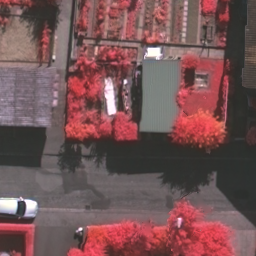

In [20]:
img

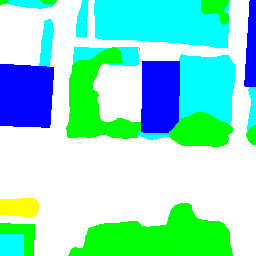

In [21]:
msk

In [12]:
img_dir

(#11740) [Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/4432.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/10596.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/6758.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/4572.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/2662.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/4207.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/5533.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/3124.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/11297.png'),Path('/home/cliff/rs_imagery/ISPRS_DATASETS/Vaihingen/vaihingen_256/images/train/11724.png')...]

In [22]:
# tfms = get_transforms()
# data = (SegmentationItemList.from_folder(img_path)
#         .split_by_rand_pct()
#         .label_from_func(get_mask, classes=msk_labels)
#         .transform(tfms, tfm_y=True, size=window_size[0])
#         .databunch(bs=batch_size)
#         .normalize(([0.4776, 0.3226, 0.3189], [0.1816, 0.1224, 0.1185])))

# data

data = DataBlock(blocks=(ImageBlock, MaskBlock(codes = msk_labels)),
    get_items=get_image_files,
    get_y=get_mask,
    splitter=RandomSplitter(seed=42),
    batch_tfms=[*aug_transforms(flip_vert=True, size=window_size), 
                Normalize.from_stats([0.4776, 0.3226, 0.3189], [0.1816, 0.1224, 0.1185])])

dls = data.dataloaders(img_path, bs=10)

#dls.show_batch()
#([0.4769, 0.3227, 0.3191], [0.1967, 0.1358, 0.1300]) -- 256
#[0.4776, 0.3226, 0.3189], [0.1816, 0.1224, 0.1185] -- 128
#[0.4752, 0.3221, 0.3183], [0.1975, 0.1363, 0.1305]

#.use_partial_data(0.1)

In [25]:
#dls.show_batch()

In [ ]:
## # instantiate the network
# define primitive set
pset = PrimitiveSet('cnn')
# add cellular encoding program symbols
#pset.add_program_symbol(cell_graph.end)
pset.add_program_symbol(cell_graph.seq)
pset.add_program_symbol(cell_graph.cpo)
pset.add_program_symbol(cell_graph.cpi)

# add convolutional operations symbols
conv_symbol = convolution.get_symbol()
pset.add_cell_symbol(conv_symbol.sepconv3x3)
pset.add_cell_symbol(conv_symbol.sepconv5x5)
pset.add_cell_symbol(conv_symbol.dilconv3x3)
pset.add_cell_symbol(conv_symbol.dilconv5x5)
pset.add_cell_symbol(conv_symbol.maxpool3x3)
pset.add_cell_symbol(conv_symbol.avgpool3x3)

def gene_gen():
    return Gene(pset, 1)

ch = Chromosome(gene_gen, 3)
graph, comp_graphs = cell_graph.generate_comp_graph(ch)

cell_graph.save_graph(graph, '../graphs/')
cell_graph.draw_graph(graph, '../graphs/')

conf = arch_config(comp_graphs=comp_graphs,
                   channels=64,
                   classes=num_classes,
                   img_size=256)

# net = get_net(conf)
net = Network(conf)

In [ ]:
graph = [AGraph(g) for g in glob.glob('../graphs/*.dot')]
_, comp_graphs = cell_graph.generate_comp_graph(graph)

conf = arch_config(comp_graphs=comp_graphs, channels=64, classes=len(msk_labels), img_size=256)

# net = get_net(conf)
net = Network(conf)

In [ ]:
def cm(preds, target, labels):
    preds = preds.argmax(dim=1).cpu().numpy().ravel()
    target = target.cpu().numpy().ravel()
    return confusion_matrix(y_true=target, y_pred=preds, labels=labels) 

def overall_acc(preds, target, labels=range(num_classes)):
    """Calculate over accuracy"""
    cm_ = cm(preds=preds, target=target, labels=labels) 
    acc = np.trace(cm_) / np.sum(cm_)
    #print(torch.tensor(acc, device='cuda'))
    return torch.tensor(acc, device='cuda')


# def acc(preds, target, labels=msk_labels):
#     """Calculate over accuracy"""
#     preds = preds.argmax(dim=1).cpu().numpy().ravel()
#     target = target.cpu().numpy().ravel()
    
#     cm = confusion_matrix(y_true=target, y_pred=preds, labels=np.arange(len(labels)))
#     ovacc = np.trace(cm) / np.sum(cm)
#     print(torch.tensor(ovacc, device='cuda'))
#     return torch.tensor(ovacc, device='cuda')

# def overall_acc(input, target):
#     target = target.squeeze(1)
#     return (input.argmax(dim=1)==target).float().mean()


metrics=overall_acc

In [ ]:
def model_splitter(model):
    return [params(model)[:132], params(model)[132:]]

In [ ]:
# weights = torch.tensor([[0.9]*5 + [1.1]]).cuda()
# loss_func = CrossEntropyLossFlat(weight=weights, axis=1) 

save = SaveModelCallback(monitor='overall_acc')

learn = Learner(dls, net, wd=1e-4, metrics=metrics, model_dir=dataset_dir, 
                cbs=save, splitter=model_splitter)

In [ ]:
# weight = torch.ones(6) #cuda.FloatTensor([1.0, 1.431, 1.682, 1.435, 40.505, 649.216])
# learn.lossfunc = CrossEntropyFlat(weight = weight)
learn.lr_find()

In [ ]:
lr = 1e-4
# learn.fit_flat_cos(70, 1e-2)
learn.fit_one_cycle(50, slice(lr))

In [ ]:
# learn.create_opt()
# learn.opt.param_groups

In [ ]:
learn.fit_one_cycle(10, 1e-3, callbacks=[cb])

In [ ]:
learn.save(dataset_dir/'stage_1')

In [ ]:
learn.load(dataset_dir/'stage_1')

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
graph = [AGraph(g) for g in glob.glob('../graphs/*.dot')]
_, comp_graphs = cell_graph.generate_comp_graph(graph)

conf = arch_config(comp_graphs=comp_graphs, channels=64, classes=len(msk_labels))
net = get_net(conf)


tfms = get_transforms(do_flip=False)
img_path = data_path/'images'
msk_path = data_path/'masks/test'
#print(img_path,'\n', msk_path)

bs = 30
data = (SegmentationItemList.from_folder(img_path)
       .split_by_folder(train='test', valid='test')
       .label_from_func(get_mask, classes=msk_labels)
       .transform(tfms, tfm_y=True, size=window_size[0])
       .databunch(bs=bs)
       .normalize(([0.4769, 0.3227, 0.3191], [0.1967, 0.1358, 0.1300])))
data

In [ ]:
model = Learner(data, net, metrics=overall_acc, model_dir=dataset_dir).load('segnet')
model.validate(data.valid_dl)

In [ ]:
#torch.load(dataset_dir/'model_0.pth')

In [ ]:
data_path = Path('/home/cliff/rs_imagery/ISPRS-DATASETS/Vaihingen/vaihingen_128_64')
img_path = data_path/'images/test'
msk_path = data_path/'masks/test'

mask_labels = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] 
num_classes = len(mask_labels) 

In [ ]:
import torchvision.transforms as transforms
bs = 20
tfms = transforms.Compose([transforms.ToTensor()])#[0.4769, 0.3227, 0.3191], [0.1967, 0.1358, 0.1300])])

criterion = nn.CrossEntropyLoss()
test_set = ISPRSDataset(img_path, msk_path, transforms=tfms)
test_loader = DataLoader(test_set, batch_size=bs, shuffle=False)

In [ ]:
def evaluate(net, loader, criterion):
    """Calculate accuracy with confusion matrix"""
    total = len(loader)
    n_labels = net.classes
    acc = 0
    val_loss = 0
    net.eval()

    for i, (imgs, true_masks), in enumerate(loader):
        imgs = imgs.to(device='cuda', dtype=torch.float32)
        true_masks = true_masks.to(device='cuda', dtype=torch.long)
    
        with torch.no_grad():
            pred_masks = net(imgs)
        
        loss = criterion(pred_masks, true_masks)
        val_loss += loss.item()
        
        pred_masks = pred_masks.argmax(dim=1).cpu().numpy().ravel()
        true_masks =true_masks.cpu().numpy().ravel()
        cm = confusion_matrix(y_true=true_masks, y_pred=pred_masks, labels=range(n_labels))
        acc +=  np.trace(cm) / np.sum(cm)

    return acc/total, val_loss/total

In [ ]:
graph = [AGraph(g) for g in glob.glob('../graphs/*.dot')]
_, comp_graphs = cell_graph.generate_comp_graph(graph)

conf = arch_config(comp_graphs=comp_graphs, channels=64, classes=len(msk_labels))
net = get_net(conf)
net.cuda()

In [ ]:
net.load_state_dict(torch.load(dataset_dir/'segnet.pth'))

In [ ]:
evaluate(net, test_loader, criterion)

In [ ]:
tfms = get_transforms(do_flip=False)
data = (SegmentationItemList.from_folder(img_path)
        .split_by_rand_pct()
        .label_from_func(get_mask, classes=msk_labels)
        .transform(tfms, tfm_y=True, size=window_size[0])
        .databunch(bs=batch_size)
        .normalize(([0.4776, 0.3226, 0.3189], [0.1816, 0.1224, 0.1185])))
#data

In [ ]:
model = Learner(data, net, metrics=overall_acc).load(dataset_dir/'model_0').split(lambda m: (m[8]))

In [ ]:

cb = SaveModelCallback(model, every='improvement', monitor='overall_acc', name='model_1')
model.fit_one_cycle(12, slice(3e-3/400, 3e-3/4), pct_start=0.3, callbacks=[cb]) 

In [ ]:
img = data.train_ds[0][0]
p = model.predict(img)
img.show(y=learn.predict(img)[0])

In [ ]:
model.validate(data.train_dl, metrics=[metrics])

In [ ]:
graph = [AGraph(g) for g in glob.glob('../graphs/*.dot')]
_, comp_graphs = cell_graph.generate_comp_graph(graph)

conf = arch_config(comp_graphs=comp_graphs, channels=64, classes=len(msk_labels))
net = get_net(conf)

In [ ]:
model = Learner(data, model=net).load(dataset_dir/'model_0')
model.export(dataset_dir/'export.pkl')
model = load_learner(dataset_dir)

In [ ]:
mode = get_subRelu_model()

In [ ]:
learn = Learner(data,mode.cuda(),metrics=accuracy)
learn.split(lambda m: m[4])
#learn.fit_one_cycle(12,slice(1e-1,2.),pct_start=0.3)

In [ ]:
def accuracy(y_true, y_preds, labels=msk_labels):
    """Calculate over accuracy"""
    cm = confusion_matrix(y_true, y_preds, np.arange(len(labels)))
    ovacc = np.trace(cm) / np.sum(cm)
    return ovacc


def metrics(y_true, y_preds, labels=msk_labels):
    """Calculate over accuracy, F1 score and Kappa coefficent"""
    # compute confusion matrix
    cm = confusion_matrix(y_true, y_preds, np.arange(len(labels)))
    gtotal = np.sum(cm)
    print("Confusion Matrix:")
    print(cm)
    print("----------------------")
    
    # compute overall accuracy
    acc = np.trace(cm) / gtotal  #np.sum([cm[i][i] for i in np.arange(len(cm))])
    print("{} pixels processed".format(gtotal))
    print("Accuracy : {:.6f}".format(acc))
    print("---------------------")
    
    # compute F1 score
    f1 = np.zeros(len(labels))
    for i in np.arange(len(labels)):
        try:
            f1[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1 Score :")
    for i, score in enumerate(f1):
        print("{}: {:.6f}".format(labels[i], score))
    print("-------------------")
        
    # compute Kappa coefficient
    pa = np.trace(cm) / gtotal
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / (gtotal * gtotal)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: {:.6f}".format(kappa))
    
    return acc, f1, kappa

In [ ]:
def evaluate(model, img_dir, step=step, window_size=window_size):
    
    all_preds = []
    all_gts = []    
    mb = master_bar(range(len(img_dir)))
    
    for i, fn in zip(mb, img_dir): 
        img = open_image(fn)
        msk = open_mask(get_msk(fn))
        emsk = open_mask(get_emsk(fn))

        img = img.data.numpy().transpose((1,2,0))
        pred = np.zeros(img.shape[:2]+(1,))
        total = count_sliding_window(img, step=step, window_size=window_size)

        for j, coords in progress_bar(enumerate(sliding_window(img, step=step, window_size=window_size)), 
                                            total=total, parent=mb):

            x,y,w,h = coords
            image_patches = np.copy(img[x:x+w, y:y+h]).transpose((2,0,1))
            image_patches = torch.from_numpy(image_patches) 
            image_patches = image_patches.squeeze()

            pred[x:x+w, y:y+h] = model.predict(Image(image_patches))[1].numpy().transpose((1,2,0))
        

        all_preds.append(pred)
        all_gts.append(emsk.data.numpy().squeeze())

        # display the img, true mask and predicted mask
        print('Results for tile #{} with true mask and predicted mask')
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255*img, dtype='uint8'))
        
        fig.add_subplot(1,3,2)
        plt.imshow(mask_to_img(msk.data.squeeze()))

        fig.add_subplot(1,3,3)
        plt.imshow(mask_to_img(pred.squeeze()))
        plt.show()
        
        # compute metrics for each tile
        metrics(pred.ravel(), emsk.data.numpy().squeeze().ravel())

        print('================================')

    # compute metrics for all the tiles
    print('Overall evaluation results for all the tiles')
    accuracy, _, _ = metrics(np.concatenate([p.ravel() for p in all_gts]).ravel(),
                           np.concatenate([p.ravel() for p in all_preds]))

    return accuracy, all_preds, all_gts

In [ ]:


#model.loss_func = torch.nn.CrossEntropyLoss(weight=w)

In [ ]:
path = Path('/home/cliff/rs_imagery/ISPRS-DATASETS/Vaihingen/vaihingen_png_format/images')
img_path = path/'test'
img_dir = get_files(img_path)

get_msk = lambda x: str(x).replace(x.parts[-3], 'masks')
get_emsk = lambda x: str(x).replace(x.parts[-3], 'masks').replace(x.parts[-2], ('e_test'))

In [ ]:
acc, preds, gts = evaluate(model, img_dir, step=128, window_size=(128, 128))

In [ ]:
[1.0, 1.431, 1.682, 1.435, 40.505, 649.216]

In [ ]:
def sliding_window(top, step=32, window_size=(128,128)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

In [ ]:
mg = get_files(mpath); mg

In [ ]:
mk = get_mk(mg[1]); mk

In [ ]:
img_ = open_image(mg[1])

In [ ]:
plt.imshow(np.asarray(255*img_.data.numpy().transpose((1,2,0)), dtype='uint8'))

In [ ]:
count_sliding_window(img_.data.numpy().transpose((2,1,0)), step=64, window_size=(256,256)) // 10

In [ ]:

#for tile, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(tile_ids)):

#print(tile.shape)
#total = count_sliding_window(tile, step=step, window_size=window_size) // batch_size
step=64; window_size=(128, 128)
img = img_.data.numpy().transpose((1,2,0))
pred_ = np.zeros(img.shape[:2]+(1,))

total = count_sliding_window(img, step=step, window_size=window_size) 
mb = master_bar(range(1))
for i in mb:
    #for batch, (data, target) in progress_bar(enumerate(trainset), total=len(trainset), parent=mb):
    for j, coords in progress_bar(enumerate(sliding_window(img, step=step, window_size=window_size)), 
                                            total=total, parent=mb):

        x,y,w,h = coords
        image_patches = np.copy(img[x:x+w, y:y+h]).transpose((2,0,1))# for x,y,w,h in coords]
        #image_patches = np.asarray(image_patches)
        #print(image_patches.shape)

        image_patches = torch.from_numpy(image_patches) #.cuda()
        #print(image_patche.shape)

        image_patches = image_patches.squeeze()

        pred_[x:x+w, y:y+h] = net1.predict(Image(image_patches))[1].numpy().transpose((1,2,0))

 

In [ ]:
p=pred_.squeeze() #.shape

In [ ]:
plt.imshow(mask_to_img(p)); plt.show()

In [ ]:
mk = get_mk(mg[1]); 
mk = open_mask(mk)
mk.show()

In [ ]:
plt.imshow(mask_to_img(mk.data.squeeze())); plt.show()

In [ ]:
mk.data.numpy().squeeze().shape

In [ ]:
_, all_preds, all_gts = test(net.model, testset_ids[:1], step=step_size)